# Classical Workflow

## Data Exploration
A crucial task for every machine learning approach is exploring the data and understanding the problem you want to solve.
Additionally you may want to make sure if there is invalid data and exclude it so it doesn't distort your accuracy and so on. 
Besides that, especially for deep learning approaches, the equalization of sample categories can play a important role 
when it comes to model performance. Let's try to tackle such an exploration task for a typical classification problem.
Our data consists of vehicle identification numbers (VIN) which are somehow similar to IMAI numbers of mobile phones. 
A few samples can be found in the pandas DataFrame below:

In [1]:
import dill
with open("dataframe.dill", "rb") as fp:
    dataframe = dill.load(fp)

dataframe.sample(frac=1).head(10)

,Vin,GENERATIONNO,DESCRIPTION,MAKENAME
61327,TMBJG9NP5H7046274,0.0,Superb (2015 - ),Skoda
80458,TMBJG9NP3J7514167,0.0,Superb (2015 - ),Skoda
48955,VSSZZZ5FZH6508003,1.0,Ateca (2016 - ),SEAT
36398,TMBJG9NP6H7022792,0.0,Superb (2015 - ),Skoda
93449,WVWZZZAUZJW097552,2.0,Golf (2017 - ),Volkswagen
98441,VSSZZZ5FZJ6530538,1.0,Ateca (2016 - ),SEAT
77324,VSSZZZ5FZJ6500548,1.0,Ateca (2016 - ),SEAT
41076,TMBJG9NP8H7040050,0.0,Superb (2015 - ),Skoda
60757,VSSZZZ5FZH6543964,1.0,Ateca (2016 - ),SEAT
31893,TMBJG9NP2H7500660,0.0,Superb (2015 - ),Skoda


Our data contains four different vehicle types namely "Skoda", "Volkswagen", "Peugot" and "SEAT". Additionally a 
description containing their model and the first year they got into production are supplied. Looking at this were 
little snippet we should notice three things: 
- every Vin contains 17 characters
- every vehicle type has been tagged with a generation number
- identical models seem to have very similar Vins

The similarity in the Vin structures is a result of how information is encoded within a single Vin. 
Such encoded data may be: 
- the place where the vehicle has been crafted
- the vehicles origin country
- first year of the models production
- ...

As there is many facturer and country related information we should generally be capable of distinguishing between
different models from looking at their Vin. A typical application for this might be a garage where an automatical 
deduction of vehicle informations from their Vin can save quite a lot of time. But before building a model to 
help us do this task let's have a little check if our above assumptions work out. 
First let's look if there is any Vin not containing 17 characters. 

In [2]:
dataframe[dataframe.Vin.apply(lambda x: len(x) < 17)].empty

True

Great! There is no Vin shorter than 17 characters, so our first assumption (at least from what we can see within this data)
is proved. Now lets check if the generation numbers always refer to the exact same model

In [3]:
dataframe.drop_duplicates(['MAKENAME', 'DESCRIPTION'])

,Vin,GENERATIONNO,DESCRIPTION,MAKENAME
888,TMBJF73T4F9023304,0.0,Superb (2015 - ),Skoda
6389,VF38D9HD8FL009350,3.0,508 (2014 - ),Peugeot
6812,VSSZZZ5FZH6517864,1.0,Ateca (2016 - ),SEAT
25056,WVWZZZAUZHP309003,2.0,Golf (2017 - ),Volkswagen


Only one entry for each generation number thus we can directly use those as labels later, Neat!
For our last assumption, for not diving to deep into details, let's check an obvious pattern: the "SEAT" 
numbers containing "VSS":

In [4]:
non_vss = dataframe[dataframe.MAKENAME == "SEAT"].Vin.apply(lambda x: "VSS" not in x)
dataframe[(dataframe.MAKENAME == "SEAT") & (non_vss)].empty

True

This seems true to be as well. As a final step let's check for duplicates before we can create an actual dataset 

In [5]:
len(dataframe[dataframe.duplicated(["Vin"])])

881

Wow! There was plenty of them. Gladly we eliminate them before proceeding

In [6]:
dataframe = dataframe.drop_duplicates("Vin")

Our main step would be creating the actual dataset. For that purpose the Vins will be binarized and equalized folds will be created. 
Sklearns [Stratified K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) and 
[Label Binarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) are the best bet for this.
As this still requires quite a lot of effort this work has been done and the dataset is stored to a folder called *dataset*.
Note that the encoded data has been stored to images as it can be interpreted as such after encoding and it will be easier
to import it to various frameworks data way. 

## Data Munging
After exploring the data we got a glimpse of an idea of how our data is structured, 
but a few important steps still need to be done. Those include: 
- creating folded sets for later cross validating our model and
- bringing the data to a format useable for training 

While for the sake of easy demonstration cross validation will not be done within 
this very simple example, let's have a look on how to absolve especially the second step 
in a resource friendly manner. The fastai package, as well as pytorch/pytorchbearer/istio etc. 
give a convenience class for that purpose. That way we even avoid RAM shortage while training 
(as the ressources will be loaded chunk by chunk).

In [8]:
from fastai.vision import ImageDataBunch
dataset = ImageDataBunch.from_folder("dataset", train="training", valid="test")
dataset

ImageDataBunch;

Train: LabelList (3040 items)
x: ImageList
Image (3, 17, 33),Image (3, 17, 33),Image (3, 17, 33),Image (3, 17, 33),Image (3, 17, 33)
y: CategoryList
3,3,3,3,3
Path: dataset;

Valid: LabelList (760 items)
x: ImageList
Image (3, 17, 33),Image (3, 17, 33),Image (3, 17, 33),Image (3, 17, 33),Image (3, 17, 33)
y: CategoryList
3,3,3,3,3
Path: dataset;

Test: None

As mentioned before the data has been preprocessed. Let's see how the first folds class sample amount are distributed:

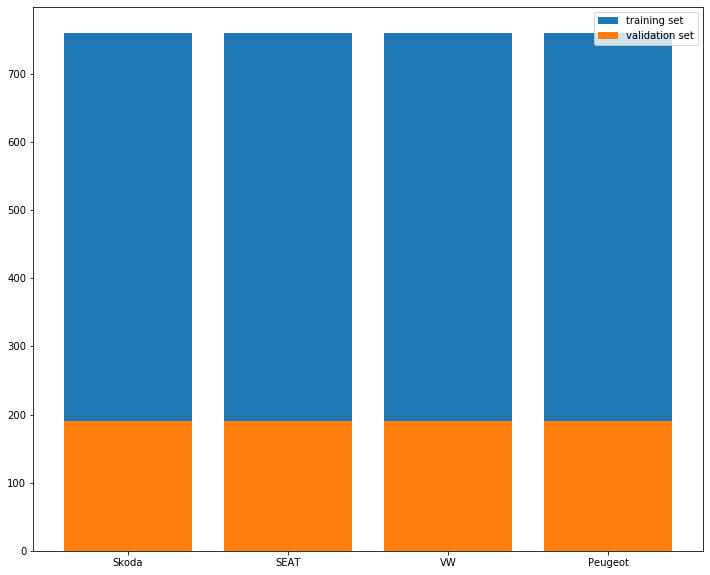

In [9]:
import numpy as np
from matplotlib import pyplot as plt

_, training_counts = np.unique(dataset.train_ds.y.items, return_counts=True)
_, test_counts = np.unique(dataset.valid_ds.y.items, return_counts=True)
fig, ax = plt.subplots(figsize=(12, 10))
ax = plt.bar([0, 1, 2, 3], height=training_counts, label="training set")
plt.bar([0, 1, 2, 3], height=test_counts, label="validation set")
plt.xticks([0, 1, 2, 3], ["Skoda", "SEAT", "VW", "Peugeot"])
plt.subplots_adjust()
plt.legend()

There is around 760 samples for each class in the test set and 190 in the validation set respectively. 
Thats satisfying for a classification task. We can procede to training a model.

## Training Process
Now that the data has been brought to a format we can work with let's setup a model 
to learn the representation. We will use the powerful fastai learning approach in order to do so.

In [10]:
from fastai.vision import *
res18_learner = cnn_learner(dataset, models.resnet18,  pretrained=False, metrics=accuracy)
res18_learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.043314,10.907436,0.250000,00:32
1,0.012109,11.012269,0.250000,00:32
2,0.004237,0.000000,1.000000,00:32
3,0.001582,0.000000,1.000000,00:32
4,0.000624,0.000000,1.000000,00:32


In order to get a better comparisson on the models performance a few other popular architectures may
be used.

In [14]:
squeeze_learner = cnn_learner(dataset, models.squeezenet1_1, pretrained=False, metrics=accuracy)
squeeze_learner.fit_one_cycle(5)
res34_learner = cnn_learner(dataset, models.resnet34, pretrained=False, metrics=accuracy)
res34_learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.103828,1.249534,0.493421,00:05
1,0.084349,3.159742,0.500000,00:05
2,0.029539,0.000001,1.000000,00:05
3,0.011040,0.000001,1.000000,00:05
4,0.004240,0.000001,1.000000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.065466,3.280815,0.250000,00:59
1,0.018270,4.128419,0.250000,01:00
2,0.006384,0.000000,1.000000,00:59
3,0.002385,0.000000,1.000000,00:59
4,0.000913,0.000000,1.000000,00:59


Another very popular trick to increase performance is to use a transfer-learning with pretrained models.
Again fastai enables us to do so as follows

In [13]:
res18_learner_pre = cnn_learner(dataset, models.resnet18, pretrained=True, metrics=accuracy)
res18_learner_pre.fit_one_cycle(5)
squeeze_learner_pre = cnn_learner(dataset, models.squeezenet1_1, pretrained=True, metrics=accuracy)
squeeze_learner_pre.fit_one_cycle(5)
res34_learner_pre = cnn_learner(dataset, models.resnet34, pretrained=True, metrics=accuracy)
res34_learner_pre.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.149541,10.459501,0.250000,00:10
1,0.041723,5.034722,0.493421,00:10
2,0.014572,0.022158,0.998684,00:10
3,0.005450,0.015032,0.998684,00:10
4,0.002130,0.015129,0.998684,00:10


Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /home/mbu93/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth
100%|██████████| 4.74M/4.74M [00:01<00:00, 4.02MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.222412,5.343445,0.250000,00:02
1,0.062398,0.000000,1.000000,00:02
2,0.021871,0.000000,1.000000,00:02
3,0.008158,0.000000,1.000000,00:02
4,0.003117,0.000000,1.000000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.173812,8.878108,0.250000,00:17
1,0.048493,12.441313,0.250000,00:17
2,0.017236,0.170833,1.000000,00:16
3,0.006428,0.000005,1.000000,00:17
4,0.002454,0.000004,1.000000,00:17


## Validating Performance & Deployment
Finally we are capable of selecting a final model for deployment. Typically this can be 
done by comparing the performance of the used models. In real world applications additionally
some steps for cross validating and serving the application would be taken which will be skipped
here to keep things simple.

In [15]:
learners = [squeeze_learner, res18_learner, res34_learner, 
            squeeze_learner_pre, res18_learner_pre, res34_learner_pre]

accuracys = [accuracy(*x.get_preds()) for x in learners]
accuracys

[tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.9987), tensor(1.)]

As the Squeezenet did the best job, practically it would be selected for deployment. To be even more sure
we might want to have a final check on its confusion matrix as well.

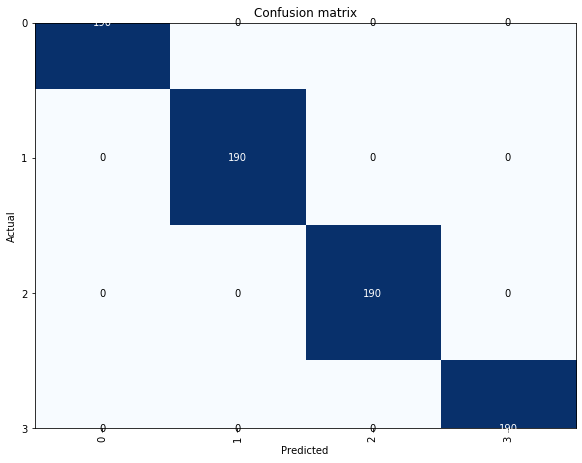

In [23]:
interp = squeeze_learner_pre.interpret()
interp.plot_confusion_matrix(figsize=(8, 8))

# Creating Pipelines for reproducing the training process

## Definitions
After we have successfully build and selected a model we are ready to automate the training process.
For that purpose KubeFlow Pipelines can be used. There are 3 ways of defining a pipeline:
- pushing a training script to a docker image and execute it directly
- using Google Cloud Storage for compiling python functions 
- writing lightweight components directly in python
While the last option has the downside of very few options to pass data and the inherent 
condition to store temporary results, we will still use it because of its ease of implementation. 
Let's first of all define our python code for training etc. 

In [15]:
def setup_data_loader() -> str:
    from fastai.vision import ImageDataBunch
    import dill
    import codecs
    bunch = ImageDataBunch.from_folder(
        "test/images", train="training", valid="test",
        size=112)
    return codecs.encode(dill.dumps(bunch), "base64").decode()


def fit_squeezenet(loader: str, storage: str, pretrained: bool = False) -> str:
    import dill
    from fastai.vision import cnn_learner, accuracy, models
    import codecs
    name: str = "squeezenet.model"
    loader = dill.loads(codecs.decode(loader.encode(), "base64"))
    learner = cnn_learner(
        loader, models.squeezenet1_0, pretrained=False, metrics=accuracy,
        silent=False, add_time=True)
    learner.fit_one_cycle(1)

    outpath = storage + "/" + name
    with open(outpath, "wb") as fp:
        dill.dump(learner, fp)

    return outpath

def fit_resnet18(loader: str, storage: str, pretrained: bool = False) -> str:
    import dill
    from fastai.vision import cnn_learner, accuracy, models
    import codecs
    name = "res18.model"
    loader = dill.loads(codecs.decode(loader.encode(), "base64"))
    learner = cnn_learner(
        loader, models.resnet18, pretrained=False, metrics=accuracy)
    learner.fit_one_cycle(1)

    outpath = storage + "/" + name
    with open(outpath, "wb") as fp:
        dill.dump(learner, fp)

    return outpath


def fit_resnet(loader: str, storage: str, pretrained: bool = False) -> str:
    import dill
    from fastai.vision import cnn_learner, accuracy, models
    import codecs
    name = "resnet.model"
    loader = dill.loads(codecs.decode(loader.encode(), "base64"))

    learner = cnn_learner(
        loader, models.resnet34, pretrained=False, metrics=accuracy)
    learner.fit_one_cycle(1)

    outpath = storage + "/" + name
    with open(outpath, "wb") as fp:
        dill.dump(learner, fp)

    return outpath


def get_accuracy(learner: str) -> float:
    from fastai.vision import accuracy
    import dill

    with open(learner, 'rb') as fp:
        learner = dill.load(fp)

    return float(accuracy(*learner.get_preds()).numpy())


def get_confusion(learner: str) -> str:
    from fastai.vision import ClassificationInterpretation
    import dill

    with open(learner, 'rb') as fp:
        learner = dill.load(fp)

    interpreter = ClassificationInterpretation.from_learner(learner)
    return str(interpreter.confusion_matrix())

## Pipeline definition
For defining the pipeline we will leverage the kfp packages capabilitys of compiling
pipeline components. First of all we will set a few path definitions etc

In [16]:
from os import path
import json
import os.path as path
import sys
from functools import wraps
from typing import Dict

import kfp.dsl as dsl
import numpy as np
from kfp import compiler
from kfp.compiler import Compiler
from kfp.components import func_to_container_op as py_convert
from kfp.dsl import ContainerOp, ExitHandler, pipeline
from kubernetes import client as k8s

OUT_DIR = '/something'
METADATA_FILE = 'mlpipeline-ui-metadata.json'
METRICS_FILE = 'mlpipeline-metrics.json'
METADATA_FILE_PATH = path.join(OUT_DIR, METADATA_FILE)
METRICS_FILE_PATH = path.join(OUT_DIR, METRICS_FILE)
SQUEEZE_FILE = "squeezenet.model"
RES18_FILE = "res18.model"
RESNET_FILE = "resnet.model"
SQUEEZE_FILE_PATH = path.join(OUT_DIR, SQUEEZE_FILE)
RES18_FILE_PATH = path.join(OUT_DIR, RES18_FILE)
RESNET_FILE_PATH = path.join(OUT_DIR, RESNET_FILE)
DEPLOYED_MODEL = SQUEEZE_FILE
BASE_IMAGE = 'mbu93/kubeflow:latest'


Now, as prototype demonstrating how deployment could be triggered, a component triggering a 
direct action within a container will be described as below

In [17]:
def markdown_metadata(result: str) -> str:
    return json.dumps({
        'outputs': [{
            'type': 'markdown',
            'source': 'The result: %s' % result,
            'storage': 'inline',
        }]
    })

def default_artifact_path() -> Dict[str, str]:
    return {
        path.splitext(METADATA_FILE)[0]: METADATA_FILE_PATH,
        path.splitext(METRICS_FILE)[0]: METRICS_FILE_PATH,
    }

def demo_op(name: str, metadata=markdown_metadata,
            is_exit_handler=False) -> ContainerOp:
    op = ContainerOp(name=name,
                     image=BASE_IMAGE,
                     command=['sh', '-c'],
                     arguments=[
                         'echo "Running step $0" && echo "$1" > $2',
                         name,
                         metadata(name),
                         METADATA_FILE_PATH,
                     ],
                     is_exit_handler=is_exit_handler)
    op.add_volume(
        k8s.V1Volume(name='volume',
                     host_path=k8s.V1HostPathVolumeSource(path='/data/out')))\
        .add_volume_mount(k8s.V1VolumeMount(name='volume', mount_path=OUT_DIR))
    return op

In order to store and load data processed in earlier stages we will also define a wrapper which mounts 
a persistent volume to every lightweight components later

In [18]:
def storage_op(func, *args):
    op = py_convert(func, base_image=BASE_IMAGE)(*args)
    op.add_volume(k8s.V1Volume(name='volume',
                               host_path=k8s.V1HostPathVolumeSource(path='/data/out')))\
      .add_volume_mount(k8s.V1VolumeMount(name='volume', mount_path=OUT_DIR))
    return op

Now as final step we define the dedicated pipeline steps

In [19]:
@pipeline(name='FastAI Training Pipeline', description='T')
def training_pipeline(pretrained: bool = False):
    deploy = demo_op('deploy', is_exit_handler=True)
    with ExitHandler(deploy):
        # setup the data loader
        setup_data = py_convert(setup_data_loader, base_image=BASE_IMAGE)()

        # fit all networks
        fit_squeeze = storage_op(fit_squeezenet, setup_data.output, OUT_DIR, pretrained)
        fit_res18 = storage_op(fit_resnet18, setup_data.output, OUT_DIR, pretrained)
        fit_res = storage_op(fit_resnet, setup_data.output, OUT_DIR, pretrained)
        fit_squeeze.default_artifact_paths = {path.splitext(SQUEEZE_FILE)[0]: SQUEEZE_FILE_PATH}
        fit_res18.default_artifact_paths = {path.splitext(RES18_FILE)[0]: RES18_FILE_PATH}
        fit_res.default_artifact_paths = {path.splitext(RESNET_FILE)[0]: RESNET_FILE_PATH}

        # get the network accuracys
        squeeze_acc = storage_op(get_accuracy, fit_squeeze.output)
        res18_acc = storage_op(get_accuracy, fit_res18.output)
        res_acc = storage_op(get_accuracy, fit_res.output)

        # get the confusion matrices
        squeeze_confusion = storage_op(get_confusion, fit_squeeze.output)
        res18_confusion = storage_op(get_confusion, fit_res18.output)
        res_confusion = storage_op(get_confusion, fit_res.output)

        # save the best model for later deployment
        models = np.array([SQUEEZE_FILE_PATH, RES18_FILE_PATH, RESNET_FILE_PATH])
        best = np.argmax([squeeze_acc.output, res18_acc.output, res_acc.output])
        globals()['DEPLOYED_MODEL'] = models[best]

## Compiling the pipeline
The pipeline described above will now be compiled using the kfg package

In [20]:
pipeline_func = training_pipeline
pipeline_filename = pipeline_func.__name__ + '.pipeline.yaml'
Compiler().compile(pipeline_func, pipeline_filename)

## Pipeline deployment
Now that everything is setup and all steps are descibed the pipeline can be run on the cluster.
For that purpose we will first create a prototype experiment to check if everything works fine. As the pretrained models parameters need to be downloaded at each container run, we will not use transfer learning for the tests to save time.

In [30]:
arguments = {'pretrained': 'False'}

#Get or create an experiment and submit a pipeline run
import kfp
client = kfp.Client()

try:
    experiment = client.create_experiment("Prototyping")
except Exception:
    experiment = client.get_experiment(experiment_name="Prototyping")
    
#Submit a pipeline run
run_name = pipeline_func.__name__ + ' test_run'
run_result = client.run_pipeline(experiment.id, run_name, pipeline_filename, arguments)


/opt/conda/lib/python3.6/site-packages/kfp/_client.py:157: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(f)
